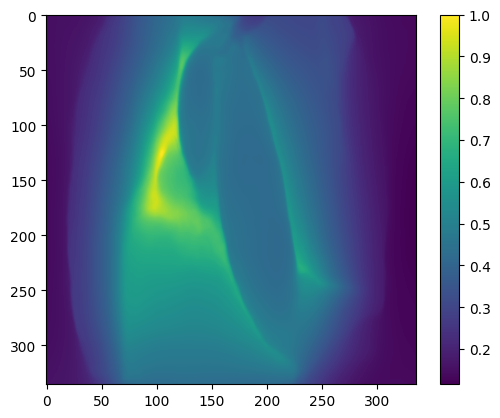

In [60]:
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch
import numpy as np
import torchvision.transforms.functional
# color = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/images/frame-000000.color.png')
# depth = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/depth/frame-000000.png',cv2.IMREAD_GRAYSCALE)
color = cv2.imread('/media/thesis_ssd/data/SurgeNet_sample/video01_000000.png')
# depth = cv2.imread('/media/thesis_ssd/data/Hamlyn/rectified01/depth01/0000000000.png',cv2.IMREAD_GRAYSCALE)
depth = np.load('/media/thesis_ssd/data/SurgeNet_sample/Depths/SurgeNet_depths/video01_000000.npy')
depth = torch.tensor(depth)
depth = torchvision.transforms.functional.resize(depth.unsqueeze(0).unsqueeze(0),[336,336])
color = cv2.resize(color, (336,336))
# depth = cv2.resize(depth, (336,336))
color = cv2.cvtColor(color,cv2.COLOR_BGR2RGB)
color = torch.Tensor(color).permute(2,0,1).cuda()/255
# color = torchvision.transforms.functional.normalize(color,[0.46888983, 0.29536288, 0.28712815],[0.24689102 ,0.21034359, 0.21188641])
normalize = torchvision.transforms.Normalize([0.46888983, 0.29536288, 0.28712815],[0.24689102 ,0.21034359, 0.21188641])
inv_normalize = torchvision.transforms.Normalize([-0.46888983/0.24689102,-0.29536288/0.21034359,-0.28712815/0.21188641],[1/0.24689102,1/0.21034359,1/0.21188641]) #Take the inverse of the normalization
# color = (color-color.min())/(color.max()-color.min())
color = normalize(color)
depth = torch.Tensor(depth).cuda().squeeze(0)
scale = torch.max(depth)
scale = 1
depth = 1/(depth)
depth = depth/torch.max(depth)
# plt.imshow(color.permute(1,2,0).cpu().detach())
plt.imshow(depth.squeeze().cpu().detach())
plt.colorbar()
plt.show()



input = torch.cat([color,depth],axis = 0).unsqueeze(0).cuda()


In [47]:
state_dict = torch.load('logs/GRN_6/checkpoint.pth',weights_only=False)
model_state_dict = state_dict['model']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


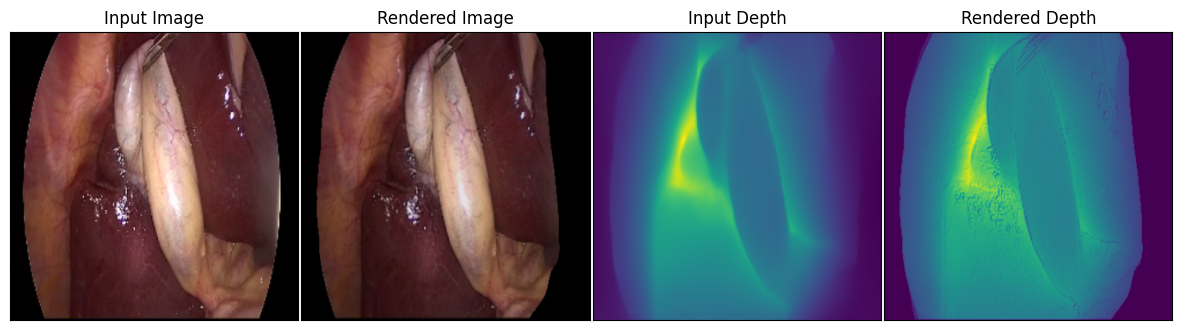

In [61]:
use_grn = True
from GRN.models.conv_unet import GaussianRegressionNetwork
from utils.recon_helpers import energy_mask, setup_camera
from GRN.grn_train_utils import initialize_params, get_pointcloud
from utils.slam_helpers import (
    transformed_params2rendervar, transformed_params2depthplussilhouette,
    transform_to_frame, l1_loss_v1, matrix_to_quaternion,transformed_GRNparams2depthplussilhouette,transformed_GRNparams2rendervar)
from diff_gaussian_rasterization import GaussianRasterizer as Renderer


intrinsics = torch.tensor([[1.03530811e+03, 0., 5.96955017e+02], [0., 1.03508765e+03,5.20410034e+02], [0., 0., 1.]]).cuda() # SCARED (Da vinci Xi) intrinsics
# intrinsics =  torch.tensor([[300., 0., 16.], [0., 300., 16.], [0., 0., 1.]]).cuda()
w2c = torch.eye(4).cuda()
cam = setup_camera(336, 336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=False,bg = [0,0,0])
render_params = {'intrinsics': intrinsics,
                    'w2c': w2c,
                    'cam': cam}

model = GaussianRegressionNetwork()
model.load_state_dict(model_state_dict)
model.cuda()
# model.eval()
output = model(input)

mask = depth > 0.0
mask = mask.tile(1,3,1,1)
mask = mask[0,0,:,:].reshape(-1)

pt_cloud,mean3_sq_dist= get_pointcloud(inv_normalize(color),depth*scale,render_params['intrinsics'],render_params['w2c'],compute_mean_sq_dist=True,mask = mask)
params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)

cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
rots = cols[:,:4]

scales_norm = cols[:,4:7]
opacities = cols[:,7][:,None]




curr_data = {'cam': render_params['cam'], 'im': inv_normalize(color), 'depth': depth*scale, 'id': 0, 'intrinsics': render_params['intrinsics'], 
                'w2c': render_params['w2c'], 'iter_gt_w2c_list': render_params['w2c']}

if use_grn:
    params['unnorm_rotations'] = rots[mask]
    params['log_scales'] = scales_norm[mask]*mean3_sq_dist[:,None].tile(1,3)
    params['logit_opacities'] = opacities[mask]
    rendervar = transformed_GRNparams2rendervar(params,params['means3D'],params['unnorm_rotations'],params['log_scales'])
    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, render_params['w2c'],
                                                    params['means3D'],params['unnorm_rotations'],params['log_scales'])
else:
        
    rendervar = transformed_params2rendervar(params,params['means3D'],params['unnorm_rotations'],params['log_scales'])
    depth_sil_rendervar = transformed_params2depthplussilhouette(params, render_params['w2c'],
                                                    params['means3D'],params['unnorm_rotations'],params['log_scales'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ render gaussians ~~~~~~~~~~~~~~~~~~~~~~~~~~~
im_pred, radius, _ = Renderer(raster_settings=render_params['cam'])(**rendervar)
depth_pred,_,_ = Renderer(raster_settings=render_params['cam'])(**depth_sil_rendervar)
# im_pred_plot = inv_normalize(im_pred)
# curr_data['im'] = inv_normalize(curr_data['im'])
fig,ax = plt.subplots(1,4,figsize = (15,5),gridspec_kw = {'wspace':0.01, 'hspace':0})
ax[1].set_title('Rendered Image')
ax[1].imshow(im_pred.permute(1,2,0).cpu().detach())
ax[0].imshow(curr_data['im'].squeeze(0).permute(1,2,0).cpu().detach())
ax[0].set_title('Input Image')
ax[3].imshow(depth_pred[0,:,:].cpu().detach())
ax[3].set_title('Rendered Depth')
ax[2].imshow(depth.squeeze().cpu().detach())
ax[2].set_title('Input Depth')
ax[0].tick_params(labelleft=False, left=False,labelbottom=False, bottom=False)
ax[1].tick_params(labelleft=False, left=False,labelbottom=False, bottom=False)
ax[2].tick_params(labelleft=False, left=False,labelbottom=False, bottom=False)
ax[3].tick_params(labelleft=False, left=False,labelbottom=False, bottom=False)
# plt.colorbar(im,ax = ax[3])

Text(0.5, 1.0, 'Input Depth')

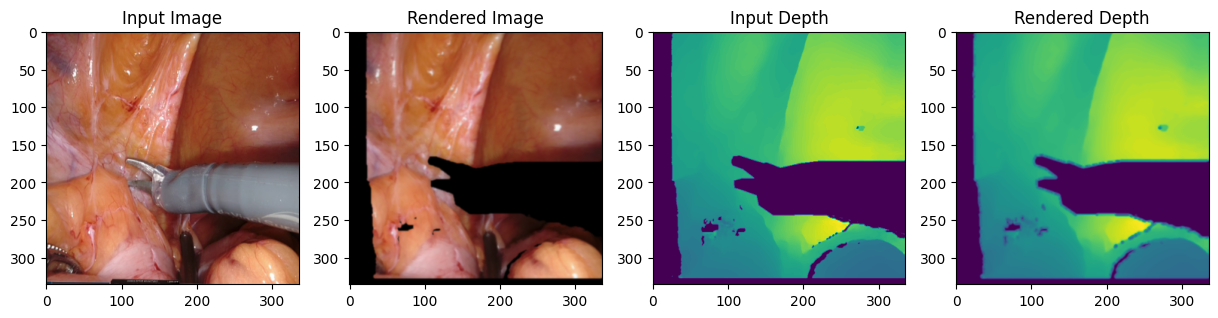

In [31]:
use_grn = False
from GRN.models.conv_unet import GaussianRegressionNetwork
from utils.recon_helpers import energy_mask, setup_camera
from GRN.grn_train_utils import initialize_params, get_pointcloud
from utils.slam_helpers import (
    transformed_params2rendervar, transformed_params2depthplussilhouette,
    transform_to_frame, l1_loss_v1, matrix_to_quaternion,transformed_GRNparams2depthplussilhouette,transformed_GRNparams2rendervar)
from diff_gaussian_rasterization import GaussianRasterizer as Renderer


intrinsics = torch.tensor([[1.03530811e+03, 0., 5.96955017e+02], [0., 1.03508765e+03,5.20410034e+02], [0., 0., 1.]]).cuda() # SCARED (Da vinci Xi) intrinsics
# intrinsics =  torch.tensor([[300., 0., 16.], [0., 300., 16.], [0., 0., 1.]]).cuda()
w2c = torch.eye(4).cuda()
cam = setup_camera(336, 336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=False,bg = [0,0,0])
render_params = {'intrinsics': intrinsics,
                    'w2c': w2c,
                    'cam': cam}

model = GaussianRegressionNetwork()
model.load_state_dict(model_state_dict)
model.cuda()
# model.eval()
output = model(input)

mask = depth > 0.1
mask = mask.tile(1,3,1,1)
mask = mask[0,0,:,:].reshape(-1)

pt_cloud,mean3_sq_dist= get_pointcloud(color,depth*scale,render_params['intrinsics'],render_params['w2c'],compute_mean_sq_dist=True,mask = mask)
params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)

cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
rots = cols[:,:4]

scales_norm = cols[:,4:7]
opacities = cols[:,7][:,None]




curr_data = {'cam': render_params['cam'], 'im': color, 'depth': depth*scale, 'id': 0, 'intrinsics': render_params['intrinsics'], 
                'w2c': render_params['w2c'], 'iter_gt_w2c_list': render_params['w2c']}

if use_grn:
    params['unnorm_rotations'] = rots[mask]
    params['log_scales'] = scales_norm[mask]*mean3_sq_dist[:,None].tile(1,3)+0.0005
    params['logit_opacities'] = opacities[mask]
    rendervar = transformed_GRNparams2rendervar(params,params['means3D'],params['unnorm_rotations'],params['log_scales'])
    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, render_params['w2c'],
                                                    params['means3D'],params['unnorm_rotations'],params['log_scales'])
else:
        
    rendervar = transformed_params2rendervar(params,params['means3D'],params['unnorm_rotations'],params['log_scales'])
    depth_sil_rendervar = transformed_params2depthplussilhouette(params, render_params['w2c'],
                                                    params['means3D'],params['unnorm_rotations'],params['log_scales'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ render gaussians ~~~~~~~~~~~~~~~~~~~~~~~~~~~
im_pred, radius, _ = Renderer(raster_settings=render_params['cam'])(**rendervar)
depth_pred,_,_ = Renderer(raster_settings=render_params['cam'])(**depth_sil_rendervar)
fig,ax = plt.subplots(1,4,figsize = (15,5))
ax[1].set_title('Rendered Image')
ax[1].imshow(im_pred.permute(1,2,0).cpu().detach())
ax[0].imshow(curr_data['im'].squeeze(0).permute(1,2,0).cpu().detach())
ax[0].set_title('Input Image')
ax[3].imshow(depth_pred[0,:,:].cpu().detach())
ax[3].set_title('Rendered Depth')
ax[2].imshow(depth.squeeze().cpu().detach())
ax[2].set_title('Input Depth')
# plt.colorbar(im,ax = ax[3])()

In [5]:
from GRN.models.conv_unet import GaussianRegressionNetwork
from utils.recon_helpers import energy_mask, setup_camera
from GRN.grn_train_utils import initialize_params, get_pointcloud
from utils.slam_helpers import (
    transformed_params2rendervar, transformed_params2depthplussilhouette,
    transform_to_frame, l1_loss_v1, matrix_to_quaternion,transformed_GRNparams2depthplussilhouette,transformed_GRNparams2rendervar)
from diff_gaussian_rasterization import GaussianRasterizer as Renderer


# intrinsics = torch.tensor([[1.03530811e+03, 0., 5.96955017e+02], [0., 1.03508765e+03,5.20410034e+02], [0., 0., 1.]]).cuda() # SCARED (Da vinci Xi) intrinsics
intrinsics =  torch.tensor([[300., 0., 16.], [0., 300., 16.], [0., 0., 1.]]).cuda()
w2c = torch.eye(4).cuda()
cam = setup_camera(336, 336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=False,bg = [0,1,0])
render_params = {'intrinsics': intrinsics,
                    'w2c': w2c,
                    'cam': cam}

model = GaussianRegressionNetwork()
model.cuda()
model.eval()
output = model(input)

mask = depth > -1
mask = mask.tile(1,3,1,1)
mask = mask[0,0,:,:].reshape(-1)

pt_cloud,mean3_sq_dist= get_pointcloud(color,depth*scale,render_params['intrinsics'],render_params['w2c'],compute_mean_sq_dist=True,mask = mask)
params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)

# cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
# rots = cols[:,:4]

# scales_norm = cols[:,4:7]
# opacities = cols[:,7][:,None]

# params['unnorm_rotations'] = rots[mask]
# params['log_scales'] = scales_norm[mask]*mean3_sq_dist[:,None].tile(1,3)
# params['logit_opacities'] = opacities[mask]


curr_data = {'cam': render_params['cam'], 'im': color, 'depth': depth*scale, 'id': 0, 'intrinsics': render_params['intrinsics'], 
                'w2c': render_params['w2c'], 'iter_gt_w2c_list': render_params['w2c']}

params['log_scales'] = torch.exp(params['log_scales'])
# params['logit_opacities'] = params['logit_opacities']*0
rendervar = transformed_GRNparams2rendervar(params,params['means3D'])
# rendervar['opacities'] = rendervar['opacities']*0.2
depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, render_params['w2c'],
                                                params['means3D'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ render gaussians ~~~~~~~~~~~~~~~~~~~~~~~~~~~
im_pred, radius, _ = Renderer(raster_settings=render_params['cam'])(**rendervar)
depth_pred,_,_ = Renderer(raster_settings=render_params['cam'])(**depth_sil_rendervar)
fig,ax = plt.subplots(1,4,figsize = (15,5))
ax[0].imshow(im_pred.permute(1,2,0).cpu().detach())
ax[0].set_title('Rendered Image')
ax[1].imshow(curr_data['im'].squeeze(0).permute(1,2,0).cpu().detach())
ax[1].set_title('Input Image')
ax[2].imshow(depth_pred[0,:,:].cpu().detach())
ax[2].set_title('Rendered Depth')
im = ax[3].imshow(depth.squeeze().cpu().detach())
ax[3].set_title('Input Depth')
plt.colorbar(im,ax = ax[3])

TypeError: transformed_GRNparams2rendervar() missing 2 required positional arguments: 'local_rots' and 'local_scales'

In [ ]:
rendervar['opacities'].min()

tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>)